In [1]:
#!/usr/bin/env python

import sys
import random
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns

import pandas as pd
from pandas import set_option
pd.options.mode.chained_assignment = None

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from scipy.stats import truncnorm
from scipy.stats import pearsonr

ModuleNotFoundError: No module named 'seaborn'

In [2]:
def ML_train(estimator, X_tr, y_tr):
    train = estimator.fit(X_tr, y_tr)
    pred = estimator.predict(X_tr)

    # Cross validation
    cvscore = cross_val_score(estimator, X_tr, y_tr, cv=5, n_jobs=10)
    score = cvscore.mean()
    print("Score with the entire dataset = %.2f" % score)
    print("mean absolute error: ", mean_absolute_error(y_tr, pred))
    print("mean squared error: ", mean_squared_error(y_tr, pred))
    print("r2 score: ", r2_score(y_tr, pred))
    print("pearson r: ", pearsonr(y_tr, pred))

    return estimator


def ML_Pred(estimator, X_te, y_te):
    pred = estimator.predict(X_te)

    print("Evaluate the error on the test data.")
    print("mean absolute error: ", mean_absolute_error(y_te, pred))
    print("mean squared error: ", mean_squared_error(y_te,pred))
    print("r2 score: ", r2_score(y_te, pred))
    print("pearson r: ", pearsonr(y_te, pred))

    return pred

In [3]:
class MLPlot:
    
    # Edit the font, font size, and axes width
    mpl.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 24
    plt.rcParams['axes.linewidth'] = 3
    
    def __init__(self, X, y, MLestimator):
        #X = MLdata[:,:-2]
        #y = MLdata[:,-1]
        #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = testsize, random_state = rstate)
        #self.qm = y_test
        #self.ml = MLestimator.predict(X_test)
        self.qm = y
        self.ml = MLestimator.predict(X)
        
    # Plot outputs
    def corrplot(self):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot()

        plt.plot(self.qm, self.ml,'ro',fillstyle='none')
        
        # determine the range
        qm_max=np.max(self.qm)
        qm_min=np.min(self.qm)
        ml_max=np.max(self.ml)
        ml_min=np.min(self.ml)
        sigma=np.std(self.qm)+np.std(self.ml)
        ax_low=min(qm_min,ml_min)-sigma
        ax_up=max(qm_max,ml_max)+sigma
        
        plt.xlim(ax_low,ax_up)
        plt.ylim(ax_low,ax_up)
        plt.plot([ax_low,ax_up],[ax_low,ax_up], '--b')

        plt.xlabel('QM i-RESP charge (e)')
        plt.ylabel('ML charge (e)')
        
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
        ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')


        #ax.xaxis.grid(True, which='minor')
        # square figure
        ax.set_aspect('equal', adjustable='box')
        plt.show()
    
    
    def cmplot(self):
        '''
        plot the reference and predicted data for direct comparison
        '''
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot()
        skip = int(len(self.qm)/1000)
        plt.plot(self.qm[::skip], color='red', marker='o', linewidth=1, label = 'QM i-RESP charge (e)')
        plt.plot(self.ml[::skip], color='blue', marker='o', linewidth=1, label = 'ML charge (e)')
        plt.legend(loc='best')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
        ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')
        
        plt.xlabel('Index')
        plt.ylabel('Atomic charge (e)')
        plt.show()

In [4]:
# Read the data from a text file
csv = pd.read_csv('Ca_all_data.txt', delimiter=',', header=None)

In [5]:
name = list()
ele_tup=('H','C','N','O','Ca')
for i in range(1,13):
    name.append(f'deg_r{i:d}')
    name.append(f'bet_r{i:d}')
    name.append(f'clust_r{i:d}')
    name.append(f'clos_r{i:d}')
for i in ('Ca','wat'):
    name.append('deg_'+i)
    name.append('bet_'+i)
    name.append('clust_'+i)
    name.append('clos_'+i)
for cut in (2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0):
    for i in ele_tup:
        name.append(i+f'_{cut:2.1f}')
for cut in (3.0,6.0):
    for i in range(5):
        for j in range(i+1):
            name.append(ele_tup[j]+ele_tup[i]+f'_{cut:2.1f}')
name.append('Cachg')

In [6]:
csv.columns=name
csv=csv[csv.columns.drop(list(csv.filter(regex='Ca_')))]

# visualize the data using UMAP

In [7]:
csv

,deg_r1,bet_r1,clust_r1,clos_r1,deg_r2,bet_r2,clust_r2,clos_r2,deg_r3,bet_r3,...,HC_6.0,CC_6.0,HN_6.0,CN_6.0,NN_6.0,HO_6.0,CO_6.0,NO_6.0,OO_6.0,Cachg
0,0.769231,0.022146,0.800000,0.812500,0.538462,0.031784,0.761905,0.684211,0.692308,0.014973,...,2.256119,0.327246,0.457257,0.297736,0.030930,6.535074,2.742365,0.620216,4.848489,1.8556
1,0.692308,0.051158,0.666667,0.764706,0.384615,0.007717,0.900000,0.619048,0.615385,0.028148,...,1.868230,0.464060,0.334295,0.348443,0.032720,3.993562,3.243850,0.595936,4.544344,2.0247
2,0.692308,0.070883,0.583333,0.764706,0.307692,0.007372,0.833333,0.590909,0.538462,0.032824,...,1.902818,0.338521,0.252735,0.232657,0.024151,5.050111,2.785759,0.425439,4.484682,1.8851
3,0.769231,0.067837,0.644444,0.812500,0.384615,0.009844,0.800000,0.619048,0.615385,0.030800,...,2.040267,0.552729,0.395611,0.359264,0.029323,4.265185,3.191460,0.641312,4.385711,1.9071
4,0.461538,0.147192,0.533333,0.500000,0.461538,0.084219,0.666667,0.541667,0.461538,0.051313,...,0.772252,0.054393,0.089891,0.051593,0.003001,7.180609,1.049976,0.122363,4.427797,2.0212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7812,0.692308,0.049532,0.638889,0.764706,0.384615,0.000000,1.000000,0.619048,0.538462,0.017298,...,1.916140,0.348588,0.324501,0.303118,0.033667,5.101842,2.671494,0.538040,4.373325,1.8637
7813,0.307692,0.003205,0.833333,0.342105,0.307692,0.021154,0.833333,0.419355,0.461538,0.074359,...,0.476700,0.145742,0.093675,0.080349,0.006223,6.456646,0.960649,0.169045,4.253812,1.8966
7814,0.230769,0.000000,1.000000,0.520000,0.230769,0.000000,1.000000,0.520000,0.769231,0.172272,...,1.233507,0.360294,0.150415,0.152058,0.006075,4.312474,2.303300,0.297769,4.757174,1.8748
7815,0.230769,0.000000,1.000000,0.520000,0.230769,0.000000,1.000000,0.520000,0.769231,0.171917,...,1.396941,0.347793,0.224490,0.175842,0.008748,4.953589,2.307237,0.381395,5.050580,1.8398


In [8]:
feat=csv[csv.columns[:-1]]
chg=csv[csv.columns[-1]]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc2695cf1d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc2695cf860>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc269638da0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc2695cfef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc2695dd278>],
 'means': []}

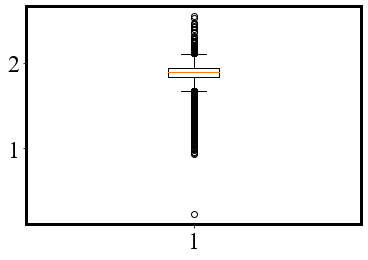

In [9]:
plt.boxplot(chg)

In [10]:
import umap

In [11]:
def get_umap(df,n_neighbors=25, min_dist=0.1, n_components=2, metric='euclidean'):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    embed = fit.fit_transform(df);
    return(embed)

In [59]:
top10_feats = feat[feat.columns[np.argsort(feat_import)[::-1]][:10]]

In [60]:
embedding = get_umap(top10_feats)
embedding.shape

(7817, 2)

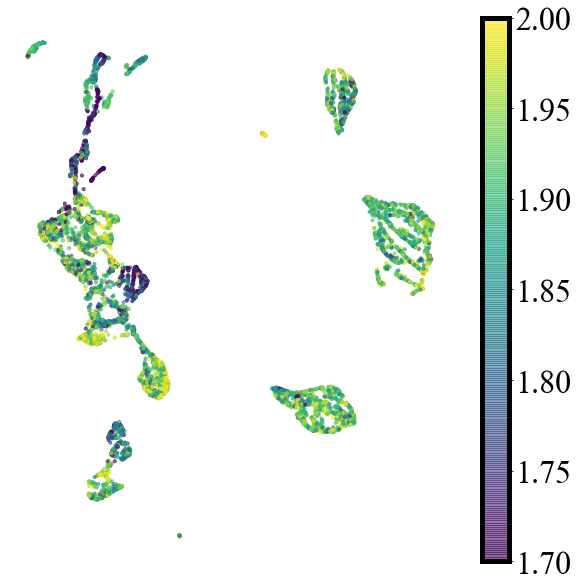

In [65]:
plt.rcParams["figure.figsize"]=(10,10)
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 32
plt.rcParams['axes.linewidth'] = 5

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

plt.scatter(embedding[:,0], embedding[:,1], s=10, alpha=0.6, vmin=1.7, vmax=2.0, c=chg, cmap='viridis')
plt.colorbar()
ax.axis('off')

plt.show()

In [14]:
rstate = 185054330

In [15]:
# Split the features using three categories
# all -> network + 2b + 3b
# sym -> 2b + 3b
# 2b

X_tr, X_te, y_tr, y_te = train_test_split(feat, chg, test_size=0.3, random_state=rstate)

feat_sym=csv[csv.columns[56:-1]]
X_tr_sym, X_te_sym = train_test_split(feat_sym, test_size=0.3, random_state=rstate)

feat_2b=csv[csv.columns[56:88]]
X_tr_2b, X_te_2b = train_test_split(feat_2b, test_size=0.3, random_state=rstate)

Text(0.5, 0, 'OO_6.0')

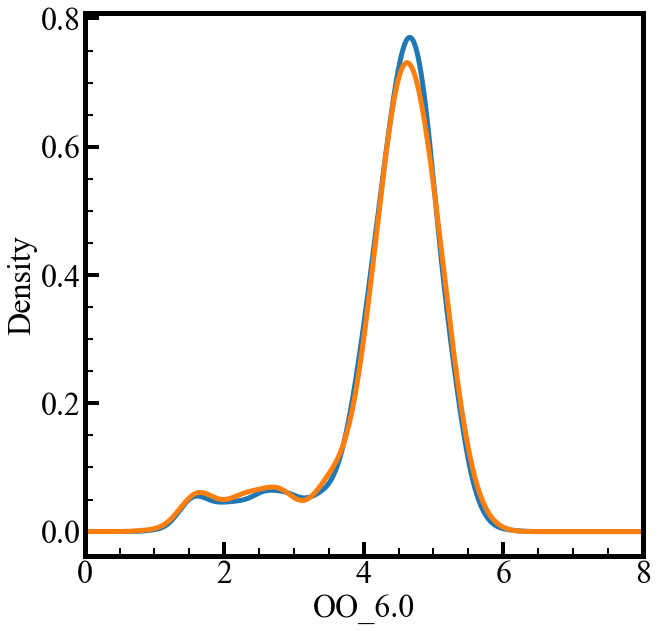

In [16]:
plt.rcParams["figure.figsize"]=(10,10)
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 32
plt.rcParams['axes.linewidth'] = 5
oo6_tr=X_tr['OO_6.0']
oo6_te=X_te['OO_6.0']

ax = oo6_tr.plot.density(lw=5,label="training")
bx = oo6_te.plot.density(lw=5,label="test")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')
ax_low = 0
ax_up = 8
plt.xlim(ax_low,ax_up)
#plt.ylim(ax_low,ax_up)
plt.xlabel('OO_6.0')
#plt.ylabel('Atomic charge (e)')
#plt.savefig("OO_6.0.pdf", format="pdf")

(-0.0005, 0.0012)

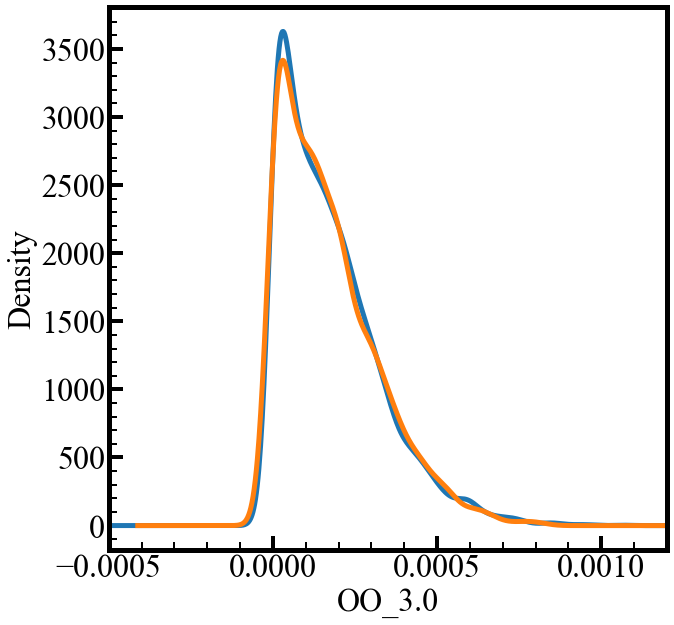

In [17]:
#plt.rcParams["figure.figsize"]=(5,5)
oo3_tr=X_tr['OO_3.0']
oo3_te=X_te['OO_3.0']

ax = oo3_tr.plot.density(lw=5)
bx = oo3_te.plot.density(lw=5)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')
plt.xlabel('OO_3.0')
ax_low = -0.0005
ax_up = 0.0012
plt.xlim(ax_low,ax_up)

#plt.savefig("OO_3.0.pdf", format="pdf")

Text(0.5, 0, 'deg_Ca')

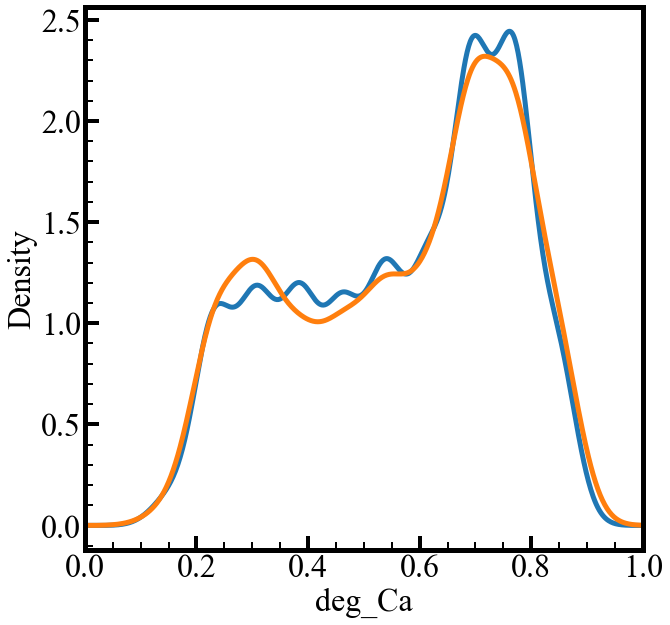

In [18]:
#plt.rcParams["figure.figsize"]=(5,5)
deg_tr=X_tr['deg_Ca']
deg_te=X_te['deg_Ca']

ax = deg_tr.plot.density(lw=5)
bx = deg_te.plot.density(lw=5)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')
ax_low = 0
ax_up = 1
plt.xlim(ax_low,ax_up)
plt.xlabel('deg_Ca')
#plt.savefig("deg_Ca.pdf", format="pdf")

Text(0.5, 0, 'Calcium charge (e)')

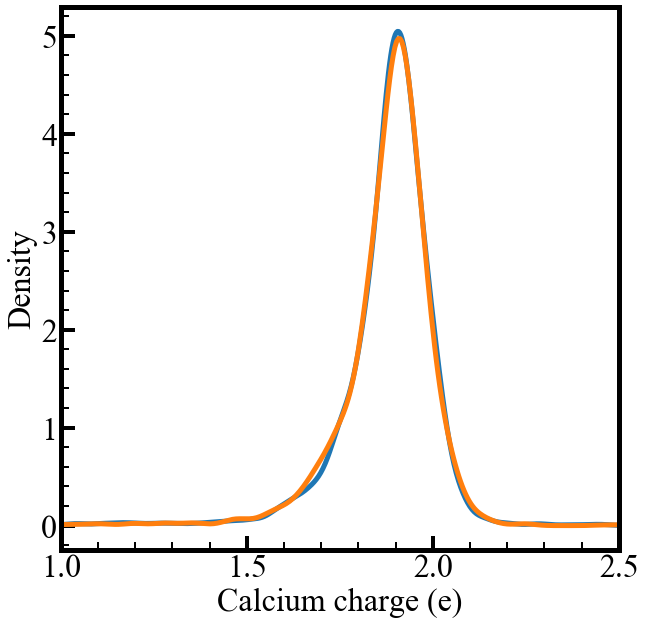

In [19]:
#plt.rcParams["figure.figsize"]=(5,5)
ax = y_tr.plot.density(lw=5)
bx = y_te.plot.density(lw=5)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')

ax_low = 1
ax_up = 2.5
plt.xlim(ax_low,ax_up)

plt.xlabel('Calcium charge (e)')
#plt.savefig("charge_iRESP.pdf", format="pdf")

In [20]:
net_par=np.array(csv[csv.columns[:56]])
newcol=4
newrow=int(net_par.size/newcol)
data = np.reshape(net_par, [newrow,newcol])
df = pd.DataFrame(data)
corrMatrix = df.corr()

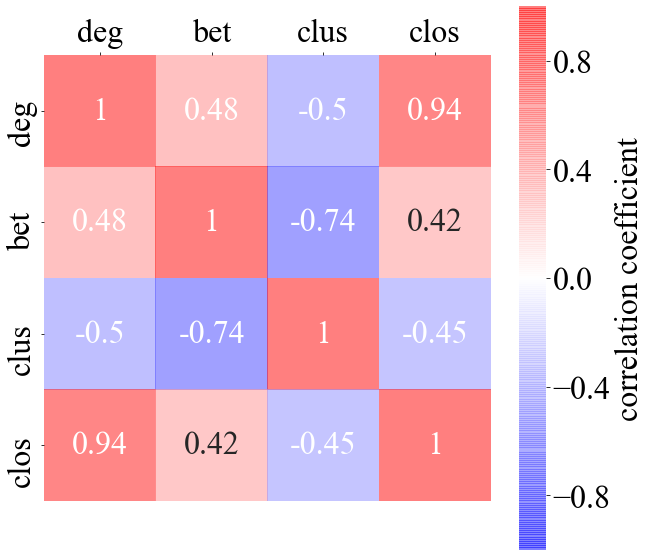

In [21]:
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 32
plt.rcParams['axes.linewidth'] = 5
plt.rcParams["figure.figsize"]=(10,10)
#plt.show()
ticks=['deg', 'bet', 'clus', 'clos']
ax=sns.heatmap(corrMatrix, cmap = 'bwr', 
              annot=True, square=True, 
              xticklabels=ticks, yticklabels=ticks, 
              vmin=-1., vmax=1.,
              alpha=0.5,
              cbar_kws={'label': 'correlation coefficient'})
ax.xaxis.tick_top()

#plt.savefig("corr_matrix.pdf", format="pdf")

In [22]:
import xgboost as xgb
rstate=random.randrange(1,999999999,1)

estimator_2b = xgb.XGBRegressor(objective='reg:squarederror', 
                             eval_metric='mae', 
                             learning_rate=0.03, 
                             max_depth=5, 
                             min_child_weight=0.1, 
                             subsample=0.7, 
                             colsample_bytree=0.7, 
                             n_estimators=500,
                             importance_type='gain',
                             booster='gbtree',
                             random_state = rstate)
XGBpipe_2b = ML_train(estimator_2b, X_tr_2b, y_tr)

ML_Pred(XGBpipe_2b, X_te_2b, y_te)

Score with the entire dataset = 0.34
mean absolute error:  0.04929250354533264
mean squared error:  0.004791829019036851
r2 score:  0.6886850363055399
pearson r:  (0.8468848264102833, 0.0)
Evaluate the error on the test data.
mean absolute error:  0.06699911219709873
mean squared error:  0.010738314904162365
r2 score:  0.3311473660306481
pearson r:  (0.5758322736150532, 2.5825449133272347e-207)


array([1.8354406, 1.9100091, 1.8546361, ..., 1.8357892, 1.903941 ,
       1.8806303], dtype=float32)

In [23]:
estimator_sym = xgb.XGBRegressor(objective='reg:squarederror', 
                             eval_metric='mae', 
                             learning_rate=0.03, 
                             max_depth=5, 
                             min_child_weight=0.1, 
                             subsample=0.7, 
                             colsample_bytree=0.7, 
                             n_estimators=500,
                             importance_type='gain',
                             booster='gbtree',
                             random_state = rstate)
XGBpipe_sym = ML_train(estimator_sym, X_tr_sym, y_tr)

ML_Pred(XGBpipe_sym, X_te_sym, y_te)

Score with the entire dataset = 0.46
mean absolute error:  0.041557445574443005
mean squared error:  0.003290065473768655
r2 score:  0.7862514272839065
pearson r:  (0.8956706201350687, 0.0)
Evaluate the error on the test data.
mean absolute error:  0.06340166440014136
mean squared error:  0.009717153632467897
r2 score:  0.39475198299113523
pearson r:  (0.6303028428582249, 5.1423115263118e-260)


array([1.8274869, 1.905645 , 1.8165511, ..., 1.8218104, 1.9188042,
       1.9066632], dtype=float32)

In [24]:
estimator = xgb.XGBRegressor(objective='reg:squarederror', 
                             eval_metric='mae', 
                             learning_rate=0.03, 
                             max_depth=5, 
                             min_child_weight=0.1, 
                             subsample=0.7, 
                             colsample_bytree=0.7, 
                             n_estimators=500,
                             importance_type='gain',
                             booster='gbtree',
                             random_state = rstate)
XGBpipe = ML_train(estimator, X_tr, y_tr)
#ML_Pred(XGBpipe, X_te, y_te)

ML_Pred(XGBpipe, X_te, y_te)

Score with the entire dataset = 0.54
mean absolute error:  0.03813841847402482
mean squared error:  0.002718733336416123
r2 score:  0.8233696639511097
pearson r:  (0.9133274967483186, 0.0)
Evaluate the error on the test data.
mean absolute error:  0.05719976594588335
mean squared error:  0.007984206296980469
r2 score:  0.5026913012375813
pearson r:  (0.7090345536790372, 0.0)


array([1.8792425, 1.9065278, 1.8167982, ..., 1.8111256, 1.9209752,
       1.9012874], dtype=float32)

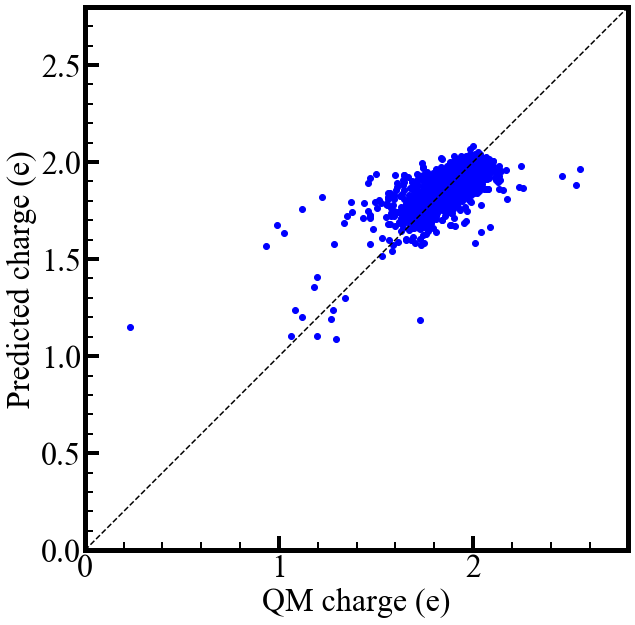

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

#plt.plot(y_tr, XGBpipe.predict(X_tr),'ko')
plt.plot(y_te, XGBpipe.predict(X_te),'bo')
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 42

# determine the range
ax_low=0
ax_up=2.8


plt.xlim(ax_low,ax_up)
plt.ylim(ax_low,ax_up)
plt.plot([ax_low,ax_up],[ax_low,ax_up], '--k')

plt.xlabel('QM charge (e)')
plt.ylabel('Predicted charge (e)')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')


#ax.xaxis.grid(True, which='minor')
# square figure
ax.set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('test_evaluation.pdf',format='pdf')

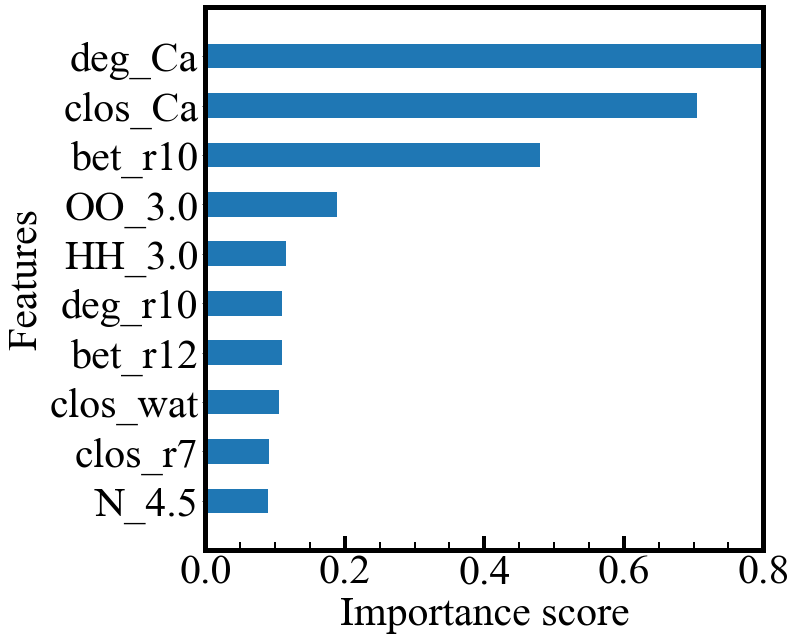

In [26]:
plt.rcParams["figure.figsize"]=(10,10)
plt.rcParams["axes.titlesize"]="large"

ax = xgb.plot_importance(XGBpipe, max_num_features=10, importance_type='gain', 
                    show_values=False, xlim = (0,0.8), xlabel="Importance score",
                   height=0.5, grid=False, title=None)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='x', which='minor', direction='in', length=8, width=2, color='k')
ax.tick_params(axis='x', which='major', direction='in', length=14, width=4, color='k')


plt.savefig("xgb_feat_imp.pdf", format="pdf")

In [27]:
feat_import=XGBpipe.feature_importances_
f1=feat_import[:56]
f2=feat_import[56:88]
f3=feat_import[88:]

In [28]:
sortFeat=np.concatenate((np.sort(f1),np.sort(f2),np.sort(f3)),axis=0)

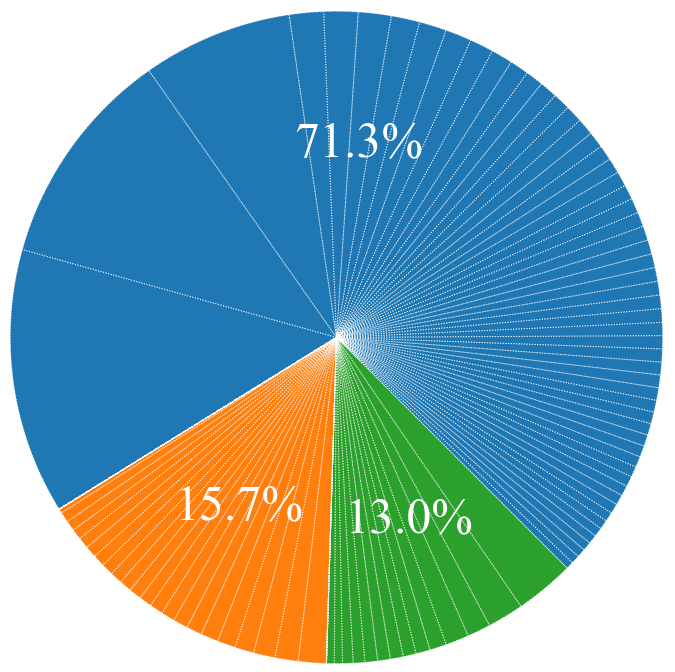

In [29]:

y = np.array([np.sum(f1),np.sum(f2),np.sum(f3)])
mylabels = ["Graph", "2-body", "3-body"]
explode = [0.1, 0, 0]

plt.pie(y, explode=None, autopct="%.1f%%", 
        startangle=-45, radius=1.5,
        wedgeprops = {'edgecolor':'None', 'lw':5},
        textprops=dict(color='w', weight='bold', fontsize=50))
explode=np.concatenate((0.1*np.ones_like(f1),np.zeros_like(f2), np.zeros_like(f3)), axis=0)

plt.pie(sortFeat, explode=None, 
        wedgeprops = {'lw': 1, 'ls':':','edgecolor':'w', 'alpha':0.8, 'fill':False},
        colors='w', startangle=-45, radius=1.5)


plt.show()

#plt.savefig("xgb_group_feat_imp.pdf", format="pdf")

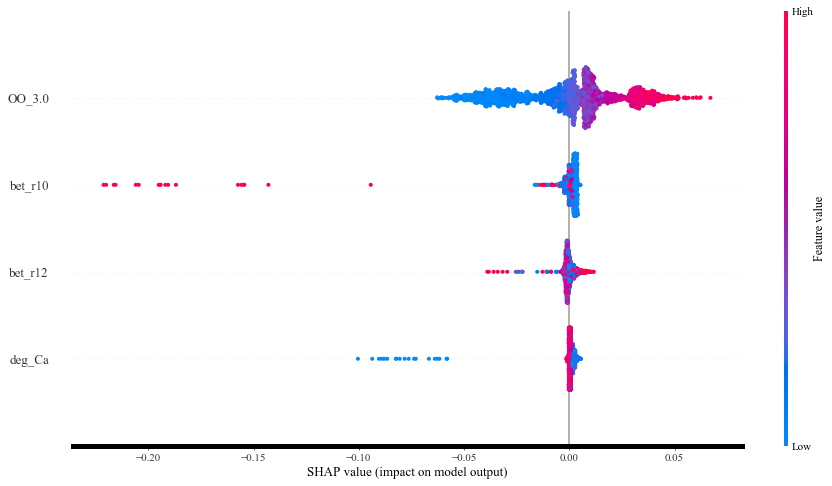

In [30]:
import shap

fig=plt.figure(figsize=(20,5))
explainer = shap.Explainer(XGBpipe)
shap_values = explainer(X_te)

# show = False has to be there to save the pdf figure.
#shap.plots.beeswarm(shap_values, max_display=5, plot_size=0.5, order=shap_values.abs.mean(0), show=False, sum_bottom_features=False)
#plt.show()

plt.tight_layout()
shap.summary_plot(shap_values[:,['OO_3.0','deg_Ca','bet_r10','bet_r12']], 
                  X_te.loc[:,['OO_3.0','deg_Ca','bet_r10','bet_r12']], 
                  show=False, plot_size=(15,8))
plt.savefig('xgboost_feat_beeswarm.pdf',format='pdf')

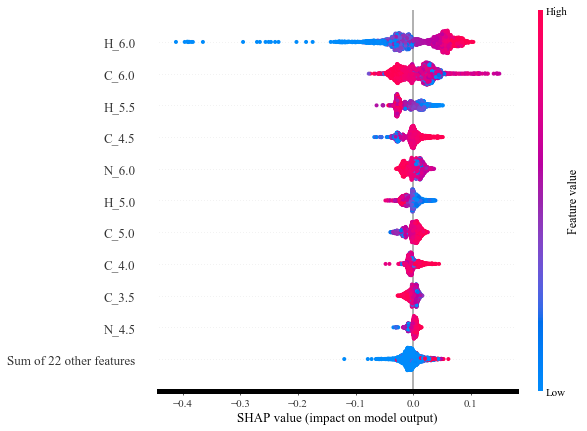

In [31]:
explainer = shap.Explainer(XGBpipe_2b)
shap_values = explainer(X_te_2b)

# show = False has to be there to save the pdf figure.
shap.plots.beeswarm(shap_values, max_display=11, plot_size=0.5, show=False)
#plt.show()
plt.savefig('xgboost_feat_beeswarm_2b.pdf',format='pdf')

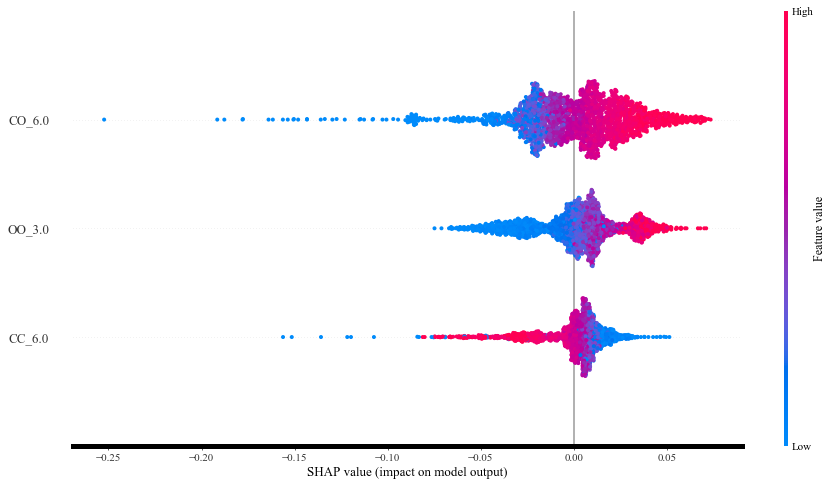

In [32]:
explainer = shap.Explainer(XGBpipe_sym)
shap_values = explainer(X_te_sym)

plt.tight_layout()
shap.summary_plot(shap_values[:,['OO_3.0','CO_6.0','CC_6.0']], 
                  X_te.loc[:,['OO_3.0','CO_6.0','CC_6.0']], 
                  show=False, plot_size=(15,8))

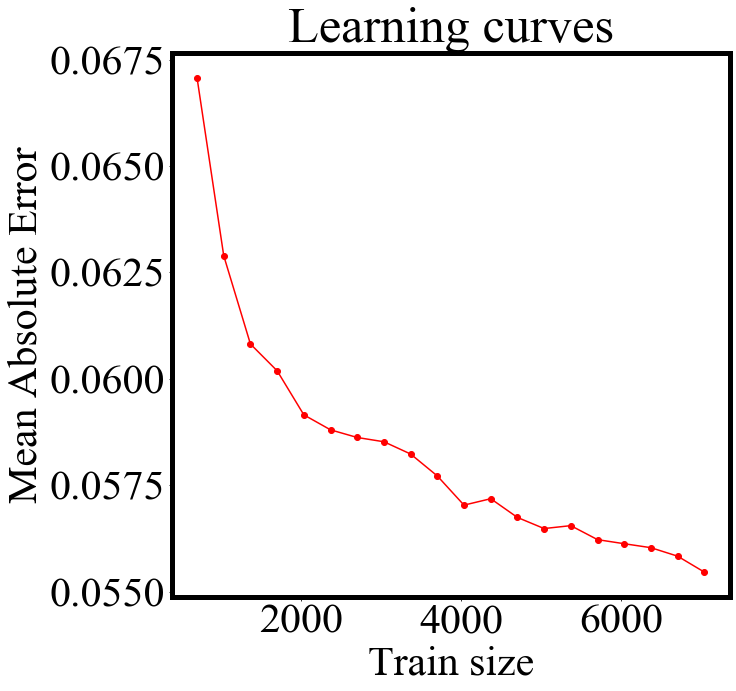

In [33]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator, feat, chg, cv=10, 
                                                                train_sizes=np.linspace(0.1, 1, 20), 
                                                                scoring="neg_mean_absolute_error", n_jobs=6)

plt.plot(train_sizes, -test_scores.mean(1), "o-", color="r")
plt.xlabel("Train size")
plt.ylabel("Mean Absolute Error")
plt.title("Learning curves")

#plt.legend(loc="best")
plt.savefig("xgb_learning_curve.pdf", format="pdf")
plt.show()

In [34]:
test_scores.mean(1)

array([-0.06706811, -0.06289246, -0.06082105, -0.06019081, -0.05915711,
       -0.05880549, -0.05862591, -0.05852531, -0.05823746, -0.05772282,
       -0.05703785, -0.05718855, -0.05674857, -0.05648783, -0.05655602,
       -0.05622744, -0.05613142, -0.05603881, -0.05583966, -0.05546559])

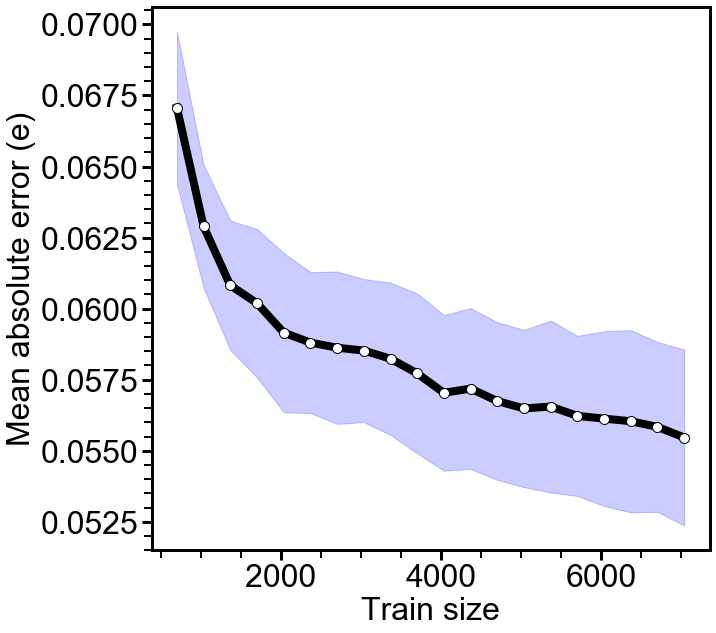

In [35]:
# Learning curve with deviation

tick=train_sizes
val=-test_scores.mean(1)
dev=test_scores.std(1)

# Edit the font, font size, and axes width
from matplotlib.ticker import MultipleLocator

mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 32
plt.rcParams['axes.linewidth'] = 3

plt.figure()
plt.plot(tick, val, marker='o', markersize=10, markerfacecolor='w', linewidth=8, color='k')
lowb=val-dev
highb=val+dev

plt.tick_params(axis='both', which='major', length=10, width=3, color='k')
plt.tick_params(axis='both', which='minor', length=8, width=2, color='k')

plt.minorticks_on()
plt.xlabel("Train size")
plt.ylabel("Mean absolute error (e)")

plt.fill_between(tick, lowb, highb, color='b', alpha=0.2)
plt.savefig("xgb_learning_curve_with_std.pdf", format="pdf")

#plt.savefig("charge_cn.pdf", format="pdf", dpi=600, bbox_inches='tight')

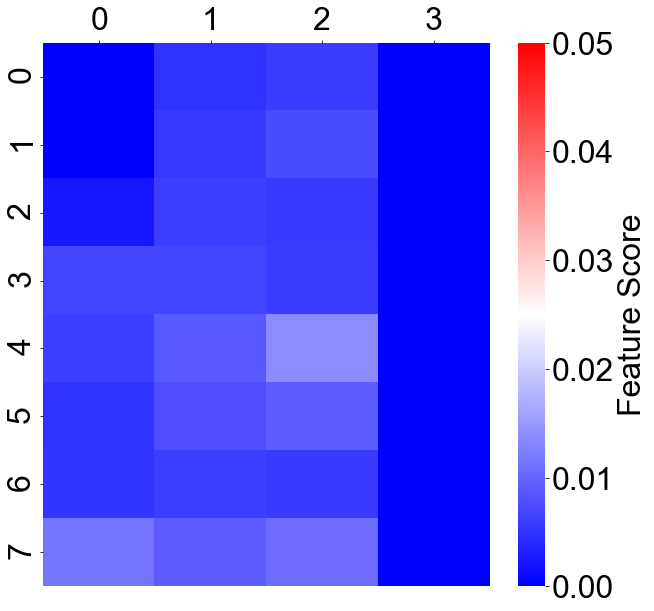

In [37]:
network_imp = np.reshape(XGBpipe.feature_importances_[:56],(14,4))
g0_imp = np.reshape(XGBpipe.feature_importances_[56:88],(8,4))
g1_imp = np.reshape(XGBpipe.feature_importances_[88:],(2,10))
g1_imp = np.transpose(g1_imp)

ax=sns.heatmap(g0_imp, cmap = 'bwr', 
              annot=False, 
              vmin=0., vmax=0.05,
              cbar_kws={'label': 'Feature Score'})
ax.xaxis.tick_top()
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 3
plt.rcParams["figure.figsize"]=(5,5)
plt.show()

In [ ]:
import pylab
import numpy             as np
import matplotlib        as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

# create colormap
# ---------------

# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 3 * 256/3 entries
upper = plt.cm.jet(np.arange(256))

# set lower part: 1 * 256/1 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/3),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
  lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])

base = np.ones((int(256/3),4))
# combine parts of colormap
cmap = np.vstack((base, lower))
cmap = np.vstack((cmap, upper))

# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])


fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)

plot_net = ax1.imshow(network_imp, cmap=cmap,vmin=0, vmax=0.05,interpolation='none')
plot_g0 = ax2.imshow(g0_imp, cmap=cmap,vmin=0, vmax=0.05,interpolation='none')
plot_g1 = ax3.imshow(g1_imp,cmap=cmap,vmin=0, vmax=0.05,interpolation='none')

ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
cbar = plt.colorbar(plot_g1)
cbar.set_label('Feature score')

#fig.savefig('xgboost_feat_imp.eps',format='eps')

In [ ]:
from sklearn.feature_selection import SelectFromModel 
# Fit model using each importance as a threshold 
thresholds = sorted(XGBpipe.feature_importances_, reverse=True) 


for thresh in thresholds[0::10]: 
    # select features using threshold 
    selection = SelectFromModel(XGBpipe, threshold=thresh, prefit=True) 
    select_X_train = selection.transform(X_tr) 

    # train model 
    selection_model = xgb.XGBRegressor(objective='reg:squarederror', 
                             eval_metric='mae', 
                             learning_rate=0.03, 
                             max_depth=5, 
                             min_child_weight=1, 
                             subsample=0.7, 
                             colsample_bytree=0.7, 
                             n_estimators=500)
    selection_model.fit(select_X_train, y_tr) 

    # eval model 
    select_X_te = selection.transform(X_te) 
    y_pred = selection_model.predict(select_X_te) 
        
    print("\t Threshold: ", thresh)
    print("\t r2: ", r2_score(y_tr, selection_model.predict(select_X_train)), "\t mae: ", mean_absolute_error(y_tr, selection_model.predict(select_X_train)))
    print("\t r2: ", r2_score(y_te, y_pred), "\t mae: ", mean_absolute_error(y_te, y_pred))

In [ ]:
# This is to make a plot for comparison of the ML performance using different features set

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
feature = ('2-body', '2-body + 3-body', 'combined')
y_pos = np.arange(len(feature))
performance = np.array([0.69, 0.79, 0.82])

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels=feature)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Test set')

plt.show()